# HydraNets for UTKFace with Tensorflow
This notebook builds multi-output network with Tensorflow.<p>
Something like this image:

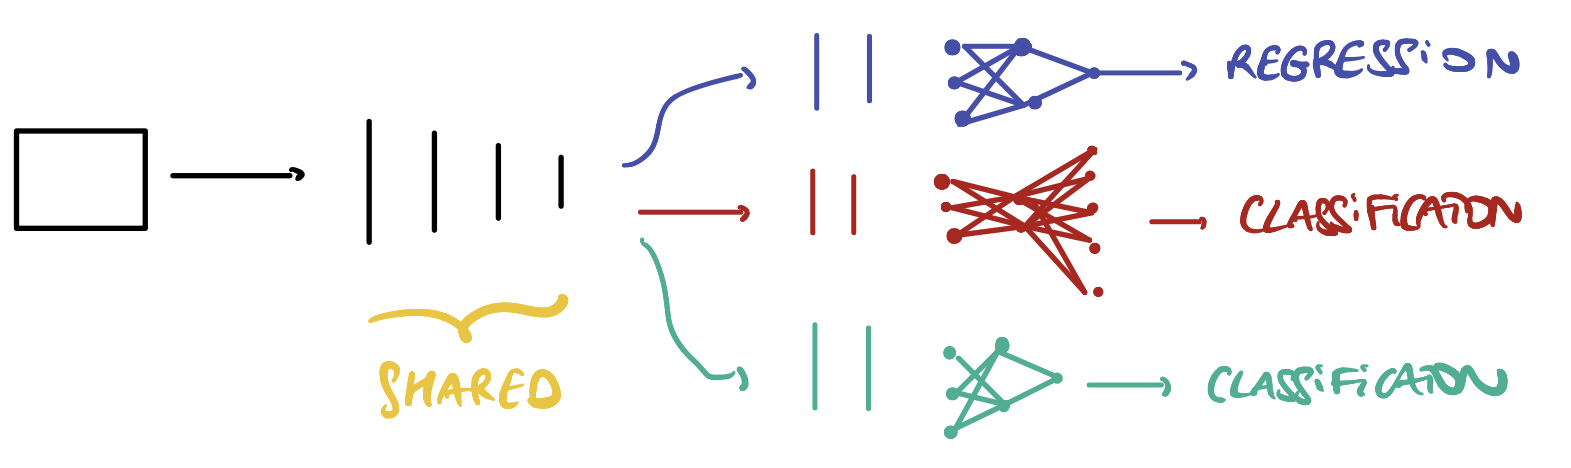

The good thing about Multi-Task Learning is that it's pretty **new**, and we **share weights**. Similarly to when transfer learning helps save time when we train our model, we're going to **save time on training, but also on inference!**. We no longer need to run 3x50 layers to have 3 tasks solved, **we can run one neural network**, and **change the heads**. With that, the network benefit from what the other tasks are learning; **it's like teaching to a class of 3 students who would share what they learn together**, instead of letting them figuring out on their own.<p>

Here's how this is going to happen: 
1.  **Load a multi-task learning dataset** named [UTK Face](https://susanqq.github.io/UTKFace/). It contains 24k images of faces, along with 3 labels: age, gender, and race/ethnicity.
2.  Explore the dataset, and realize that we need to solve **3 tasks**: binary classification (gender), multi-class classification (race), and regression (age).
3.  With PyTorch, going to **create a DataLoader that returns multiple labels**.
4.  To solve the tasks, we'll work with a **pretrained ResNet model**, **behead it**, and **create 3 new heads**.
5.  Finally, we'll **train the model** on a training dataset, and **test on the validation dataset**.
<p>

This notebook uses TensorFlow and while on a single glance it might look simple, it will be challenging to **get a great accuracy with it**. If you're new to TensorFlow, you're gonna love it: We're going to **create everything from scratch**.

In [1]:
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1 — The UTK Face Dataset
The UTK Face Dataset can be downloaded from [here](https://susanqq.github.io/UTKFace/)<p>
**The following wget command will download our dataset.**

![](https://images.squarespace-cdn.com/content/v1/5d6567d1afafe900010b2c70/1567268409336-V7HQTOKOVGT6OYHAER5D/utk-1.jpg)

In [2]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip

--2022-12-21 21:06:05--  https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.156.60
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.156.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131852014 (126M) [application/zip]
Saving to: ‘UTKFace.zip’

UTKFace.zip         100%[===================>] 125.74M  18.2MB/s    in 7.7s    

2022-12-21 21:06:13 (16.3 MB/s) - ‘UTKFace.zip’ saved [131852014/131852014]



In [3]:
!unzip "/content/UTKFace.zip" -d 'UTKFace'

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/UTKFace/30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: UTKFace/__MACOSX/UTKFace/._66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: UTKFace/UTKFace/40_0_1_20170117134411786.j

In [4]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import keras
from tensorflow import keras
import glob
import os
import re

In [5]:
image_paths = sorted(glob.glob("/content/UTKFace/UTKFace/*.jpg.chip.jpg"))
print(image_paths[0])

/content/UTKFace/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg


# 2 — Very fast Data Exploration
Based on the dataset, you can see that the entire thing is on the name of the images.<p>
For example, the image **UTKFace/100_0_0_20170112213500903.jpg.chip.jpg** can be interpreted as follows:

* UTKFace/ is a prefix
* **100 is the age**
* **0 is the gender** (0: male, 1: female)
* **0 is the race** (0:White, 1:Black, 2:Asian, 3:Indian, 4:Other)
* The rest is the date and the extension (jpg)

So: **[age] _ [gender] _ [race] _ [date&time].jpg**


The example above is the filename for image number 0. Let's pray the image we see is a very old white man.🙏🏻


In [6]:
image_paths = sorted(glob.glob("/content/UTKFace/UTKFace/*.jpg.chip.jpg"))

images = []
ages = []
genders = []
races = []
paths = []

for path in image_paths:
    filename = path[25:].split("_")
    if len(filename)==4:
        paths.append(path)
        images.append(np.array(Image.open(path)))
        ages.append(int(filename[0]))
        genders.append(int(filename[1]))
        races.append(int(filename[2]))

In [7]:
dataset_dict = {
    'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'
    },
    'gender_id': { 0: 'Male', 1: 'Female'
    }
}

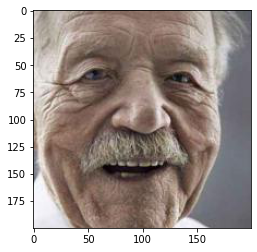

Age: 100
Gender: Male
Race: White


In [8]:
idx = np.random.randint(len(images))

plt.imshow(images[0])
plt.show()

print("Age: "+str(ages[0]))
print("Gender: "+str(dataset_dict['gender_id'][genders[0]]))
print("Race: "+str(dataset_dict['race_id'][races[0]]))

## Normalization

In [9]:
min_age_value, max_age_value = min(ages), max(ages)
log_age_values = np.log10(ages)
max_age_log_value = log_age_values.max()
print('MAX AGE VALUE', max_age_value)
print('MIN AGE VALUE', min_age_value)
print('MAX AGE LOG VALUE', max_age_log_value)

MAX AGE VALUE 116
MIN AGE VALUE 1
MAX AGE LOG VALUE 2.0644579892269186


In [10]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - min_age_value)/(max_age_value - min_age_value)

def get_log_age_value(original_age_value):
    return np.log10(original_age_value)/max_age_log_value

def get_original_age_from_log_value(log_age_value):
    return np.exp(log_age_value) * max_age_log_value

def get_original_age_value(normalized_age_value):
    return normalized_age_value * (max_age_value - min_age_value) + min_age_value

## More Data Exploration

Usually, we should seek for balance in the dataset, we should explore it. Let's not loose to much time here as it's not our #1 Priority.<p>
👉 Kaggle has a competition open for this dataset, and they released [a starter for the data visualization](https://www.kaggle.com/svenknoblauch/utkface-data-exploration). This notebook uses directly in the work!

In [11]:
import seaborn as sns
import pandas as pd

d = {'age': ages, 'gender': genders, 'race': races}
df = pd.DataFrame(data=d)

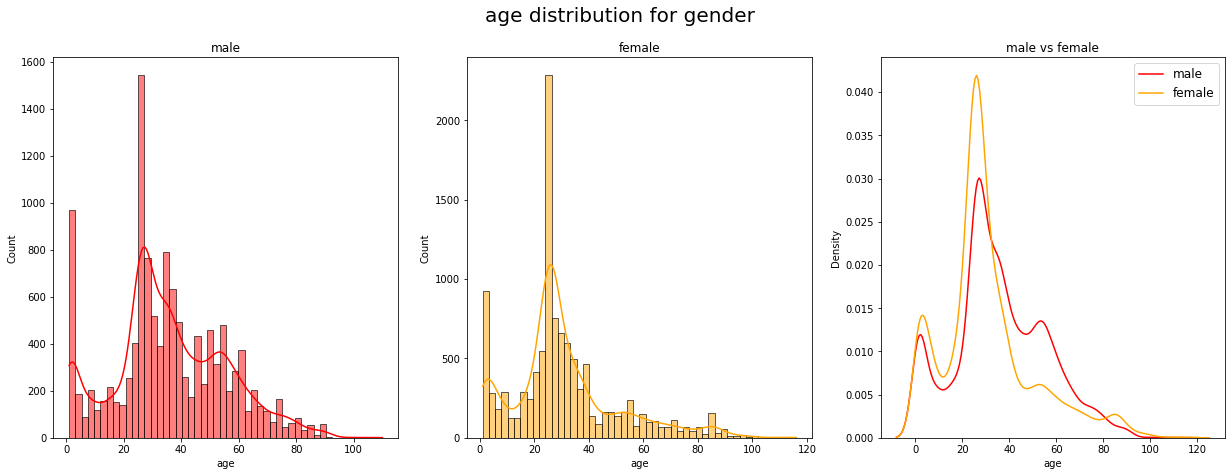

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('age distribution for gender', fontsize=20)

df_age_male = df.groupby('gender').get_group(0)
df_age_female = df.groupby('gender').get_group(1)
sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
ax1.title.set_text("male")
ax2.title.set_text("female")


sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.title.set_text("male vs female")

plt.show()

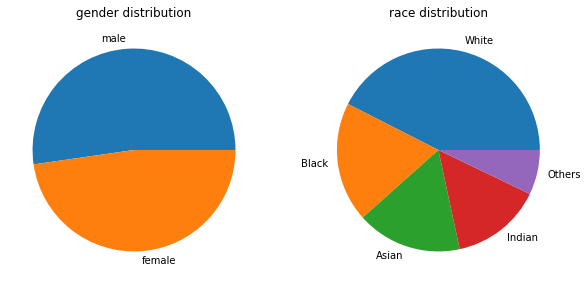

In [13]:
pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
df.gender.value_counts().plot(kind='pie', labels=["male", "female"], pctdistance=0.5, ax = ax1)
ax1.yaxis.set_visible(False)
ax1.title.set_text('gender distribution')

df.race.value_counts().plot(kind='pie', labels=["White", "Black", "Asian", "Indian", "Others"], pctdistance=0.5, ax = ax2)
ax2.yaxis.set_visible(False)
ax2.title.set_text('race distribution')

plt.show()

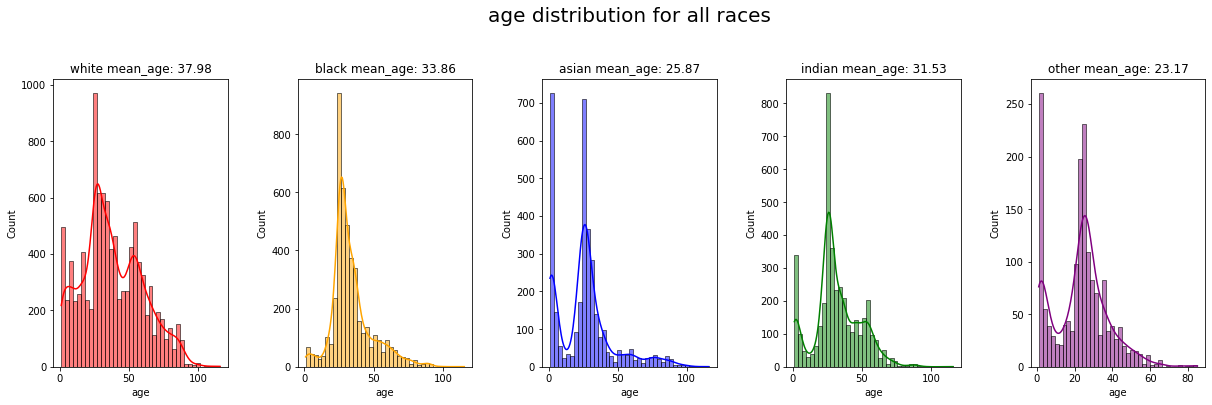

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('age distribution for all races', fontsize=20, y=1.1)
fig.tight_layout()

df_race_white = df.groupby('race').get_group(0)
sns.histplot(data=df_race_white, x="age", kde=True, color="red", ax=ax1, bins=40)
ax1.title.set_text("white mean_age: "+"%.2f" % df_race_white.mean()["age"])

df_race_black = df.groupby('race').get_group(1)
sns.histplot(data=df_race_black, x="age", kde=True, color="orange", ax=ax2, bins=40)
ax2.title.set_text("black mean_age: "+"%.2f" % df_race_black.mean()["age"])

df_race_asian = df.groupby('race').get_group(2)
sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", ax=ax3, bins=40)
ax3.title.set_text("asian")
ax3.title.set_text("asian mean_age: "+"%.2f" % df_race_asian.mean()["age"])

df_race_indian = df.groupby('race').get_group(3)
sns.histplot(data=df_race_indian, x="age", kde=True, color="green", ax=ax4, bins=40)
ax4.title.set_text("indian mean_age: "+"%.2f" % df_race_indian.mean()["age"])

df_race_other = df.groupby('race').get_group(4)
sns.histplot(data=df_race_other, x="age", kde=True, color="purple", ax=ax5, bins=40)
ax5.title.set_text("other mean_age: "+"%.2f" % df_race_other.mean()["age"])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

# 3 — Create a Multi-Task DataLoader with TensorFlow

In TensorFlow, we usually need to create 2 elements:
* A Dataset — That will do exactly what we've done right above
* A Dataloader — That will convert our data in TensorFlow format

## Dataset Minimal Code
Unlike the PyTorch, we will create a pandas DataFrame that has the path to the images, ages, genders and races as columns. We will then use this DataFrame to create DataLoaders. We don't need to create a `UTKFace` class as we did for PyTorch

In [15]:
# Just in case if images don't load properly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [17]:
# Create the dataframe
df['image'] = paths
df = df[['image', 'age', 'gender', 'race']]
df

,image,age,gender,race
0,/content/UTKFace/UTKFace/100_0_0_2017011221350...,100,0,0
1,/content/UTKFace/UTKFace/100_0_0_2017011221524...,100,0,0
2,/content/UTKFace/UTKFace/100_1_0_2017011018372...,100,1,0
3,/content/UTKFace/UTKFace/100_1_0_2017011221300...,100,1,0
4,/content/UTKFace/UTKFace/100_1_0_2017011221330...,100,1,0
...,...,...,...,...
23699,/content/UTKFace/UTKFace/9_1_3_201612202228563...,9,1,3
23700,/content/UTKFace/UTKFace/9_1_3_201701042229494...,9,1,3
23701,/content/UTKFace/UTKFace/9_1_4_201701032006373...,9,1,4
23702,/content/UTKFace/UTKFace/9_1_4_201701032008147...,9,1,4


## Train/Test Split

Unlike the Pytorch notebook, we will split the data into train and test sets using a `ImageDataGenerator` generator that will transform the images and split the data into training and validation subsets 

## Dataloader

In [18]:
def preprocess_image(img) :
    mean = [0.485, 0.456, 0.406] # ImageNet
    std = [0.229, 0.224, 0.225] # ImageNet
    img = (img - mean) / std
    return img

In [19]:
BATCH_SIZE = 64

# Create a generator to create the train and validation dataloaders
generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_image)

train_dataloader = generator.flow_from_dataframe(df, directory=None, x_col='image', y_col=['age', 'gender', 'race'], class_mode='multi_output',
                                                 color_model='rgb', target_size=(32,32), batch_size=BATCH_SIZE, shuffle=True, subset='training')

valid_dataloader = generator.flow_from_dataframe(df, directory=None, x_col='image', y_col=['age', 'gender', 'race'], class_mode='multi_output',
                                                 color_model='rgb', target_size=(32,32), batch_size=BATCH_SIZE, shuffle=False, subset='validation')

train_steps = len(train_dataloader)//64
valid_steps = len(valid_dataloader)//64

Found 16593 validated image filenames.
Found 7111 validated image filenames.


In [20]:
def imshow(img):
    # Unnormalize the image using the ImageNet mean and standard deviation. 
    # Unlike for PyTorch notebook we will need to denormalize using the mean and standard deviation of ImageNet
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = tf.image.resize(img, (32,32))
    # convert to Numpy
    npimg = img.numpy()
    # No need to transpose the image in order to get the correct color unlike done for PyTorch    
    npimg = Image.fromarray(npimg.astype(np.uint8))
    plt.imshow(npimg)
    plt.show()

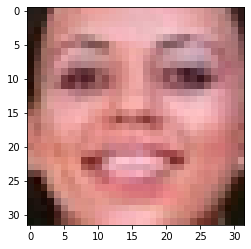

38
0.3217391304347826
Female
White


In [21]:
sample = next(train_dataloader)
imshow(sample[0][0])

# Print the age
print(sample[1][0][0])
print(get_normalized_age_value(sample[1][0][0]))

print(dataset_dict['gender_id'][sample[1][1][0]])
print(dataset_dict['race_id'][sample[1][2][0]])

# 4 — Multi-Task Neural Network with TensorFlow

In this part, we want to:
1. Define a Base Neural Network
2. Create the Heads
3. Train it
4. Test it


### Define the Base Model
In this part, we're going to load a pretrained Resnet18. **The main focus is on how to add layers to a pretrained network, no matter the nework, so if desired, we can load an Inception v3 or any other pretrained Network**


## Create the HydraNet class


Unlike the loaded pretrained model, the final layer is called predictions. If we want to add layers to that, we need to make sure that the layer isn't included. This is done passing `include_top=False` as argument when loading the model and the connect the last layer to the new layer


Here's an example when changing this final layer to a 10 neuron output:
```python
self.net = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
self.predictions = tf.keras.layers.Dense(10)(self.net.outputs[-1])
```

We can also use the OrderedDict method and have a set of layers (a real head!). However, in this notebook, the OrderedDict method is not used. TensorFlow has a sub-classing method, just like the method used for PyTorch version of this notebook. However, that approach is not used to due issues with model-subclassing and model training

In [22]:
class HydraNetModified:
        
    def __new__(self, net) :
        
        # Make sure the base model is not trainable
        net.trainable = False
    
        # flatten = tf.keras.layers.Flatten(name='flatten')(net.outputs[-1])
        avg_pool = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(net.outputs[-1])

        age_head = tf.keras.layers.Dense(512, activation='relu', name='age_dense')(avg_pool)
        age_head = tf.keras.layers.Dense(1, activation='relu', name='age_output')(age_head)

        gender_head = tf.keras.layers.Dense(512, activation='relu', name='gender_dense')(avg_pool)
        gender_head = tf.keras.layers.Dense(1, activation='sigmoid', name='gender_output')(gender_head)

        race_head = tf.keras.layers.Dense(512, activation='relu', name='race_dense')(avg_pool)
        race_head = tf.keras.layers.Dense(5, activation='softmax', name='race_output')(race_head)

        model = tf.keras.Model(inputs=net.inputs, outputs=[age_head,gender_head,race_head]) 
        model._name = 'HydraNet'
        
        return model

In [23]:
net = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
net._name = 'HydraNetResNet50'

model = HydraNetModified(net)


race_loss = tf.keras.losses.SparseCategoricalCrossentropy()
gender_loss = tf.keras.losses.BinaryCrossentropy()
age_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

race_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
gender_metrics = tf.keras.metrics.BinaryAccuracy()
age_metrics = tf.keras.metrics.MeanAbsoluteError()



lr = 1e-4
momentum = 0.09
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

## Train the Model

Unlike PyTorch, we don't need to create a logger to store the training and validation losses. However, we are going to create a custom callback for Training so that we can get the output of the training and validation losses in the format just like the one used in the PyTorch.

In [24]:
class TrainingCallback(tf.keras.callbacks.Callback) :

    def on_epoch_begin(self, epoch, logs=None):
        print('EPOCH ', epoch+1)

    def on_epoch_end(self, epoch, logs=None):
        print("Training Losses: Race: {}, Gender: {}, Age: {}".format(logs['race_output_loss'], 
                                                                      logs['gender_output_loss'], 
                                                                      logs['age_output_loss']))
        print("Validation Losses: Race: {}, Gender: {}, Age: {}".format(logs['val_race_output_loss'], 
                                                                      logs['val_gender_output_loss'], 
                                                                      logs['val_age_output_loss']))
        
        print('Average Losses — Training: {} | Validation {}'.format(logs['loss']/train_steps, logs['val_loss']/valid_steps))
        print()

In [25]:
model.compile(optimizer=optimizer, 
              loss={
                  'age_output': age_loss, 
                  'race_output': race_loss, 
                  'gender_output': gender_loss},
              loss_weights={
                  'age_output': 1.0, 
                  'race_output': 1.0, 
                  'gender_output': 1.0},
              metrics={
                  'age_output': race_metrics,  
                  'race_output': gender_metrics,
                  'gender_output': age_metrics})

In [26]:
history = model.fit(train_dataloader, epochs=30, steps_per_epoch=train_steps, verbose=0, 
          validation_data=valid_dataloader, validation_steps=valid_steps,
         callbacks=[TrainingCallback()])

EPOCH  1
Training Losses: Race: 8.112678527832031, Gender: 1.665520191192627, Age: 25.681690216064453
Validation Losses: Race: 1.2734464406967163, Gender: 0.9895184636116028, Age: 38.29528045654297
Average Losses — Training: 8.864972114562988 | Validation 40.55824279785156

EPOCH  2
Training Losses: Race: 3.1183862686157227, Gender: 0.9702635407447815, Age: 17.624425888061523
Validation Losses: Race: 1.8313567638397217, Gender: 0.6274605989456177, Age: 39.63349151611328
Average Losses — Training: 5.4282684326171875 | Validation 42.092308044433594

EPOCH  3
Training Losses: Race: 2.4970486164093018, Gender: 0.9895516633987427, Age: 16.08572769165039
Validation Losses: Race: 1.4471566677093506, Gender: 0.7063061594963074, Age: 39.54132080078125
Average Losses — Training: 4.8930816650390625 | Validation 41.69478225708008

EPOCH  4
Training Losses: Race: 2.3085882663726807, Gender: 0.9236161708831787, Age: 16.634624481201172
Validation Losses: Race: 2.0005979537963867, Gender: 0.5592472553

In [27]:
model.save('saved_model/HydraNetResNet50Modified')

## Show the Results

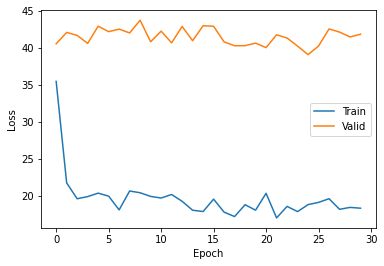

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

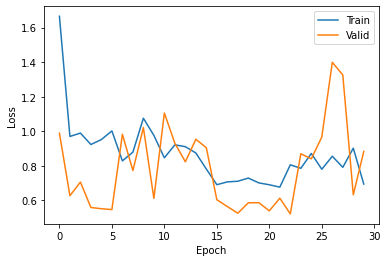

In [29]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

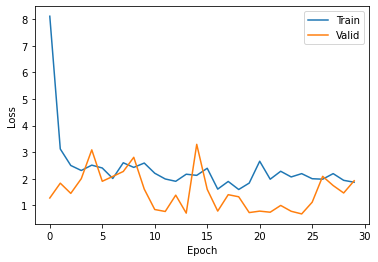

In [30]:
plt.plot(history.history['race_output_loss'])
plt.plot(history.history['val_race_output_loss'])
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

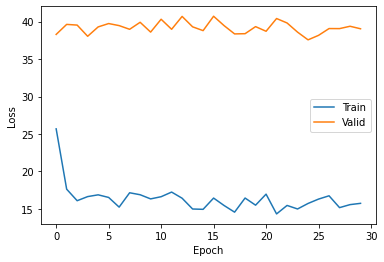

In [31]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Inference

In [32]:
# Get the first 10 filenames of the images in our valid dataloader 
test_names = valid_dataloader.filenames[:10]

# Create a test dataframe using the image filenames
test_df = df[df['image'].isin(test_names)]
display(test_df)

# Use the test_df to create a dataloader for the test set with batch_size as 1. Also subset argument wont be used since the goal is to use all 10 images
test_dataloader = generator.flow_from_dataframe(test_df, directory=None, x_col='image', y_col=['age', 'gender', 'race'], class_mode='multi_output',
                                                 color_model='rgb', target_size=(32,32), batch_size=1, shuffle=False)

,image,age,gender,race
0,/content/UTKFace/UTKFace/100_0_0_2017011221350...,100,0,0
1,/content/UTKFace/UTKFace/100_0_0_2017011221524...,100,0,0
2,/content/UTKFace/UTKFace/100_1_0_2017011018372...,100,1,0
3,/content/UTKFace/UTKFace/100_1_0_2017011221300...,100,1,0
4,/content/UTKFace/UTKFace/100_1_0_2017011221330...,100,1,0
5,/content/UTKFace/UTKFace/100_1_0_2017011221503...,100,1,0
6,/content/UTKFace/UTKFace/100_1_0_2017011719542...,100,1,0
7,/content/UTKFace/UTKFace/100_1_0_2017011921205...,100,1,0
8,/content/UTKFace/UTKFace/100_1_2_2017010517484...,100,1,2
9,/content/UTKFace/UTKFace/100_1_2_2017011221361...,100,1,2


Found 10 validated image filenames.


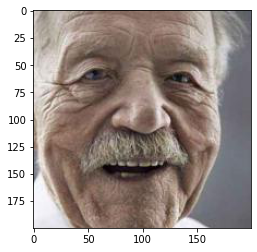

Age : 100  | Predicted : 34
Gender : Male  | Predicted : Female
Race : White  | Predicted : Black




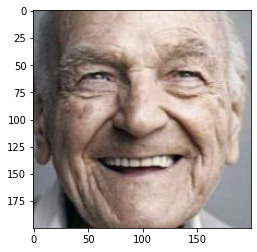

Age : 100  | Predicted : 34
Gender : Male  | Predicted : Female
Race : White  | Predicted : Black




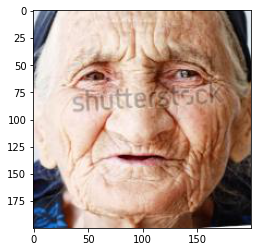

Age : 100  | Predicted : 47
Gender : Female  | Predicted : Female
Race : White  | Predicted : Black




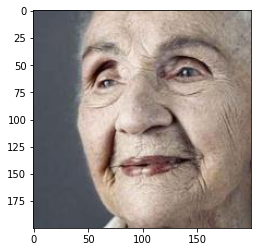

Age : 100  | Predicted : 32
Gender : Female  | Predicted : Female
Race : White  | Predicted : Black




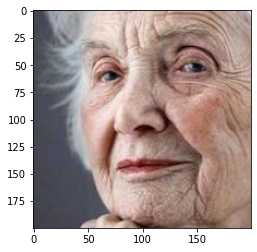

Age : 100  | Predicted : 37
Gender : Female  | Predicted : Female
Race : White  | Predicted : Black




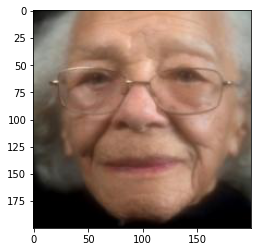

Age : 100  | Predicted : 37
Gender : Female  | Predicted : Male
Race : White  | Predicted : White




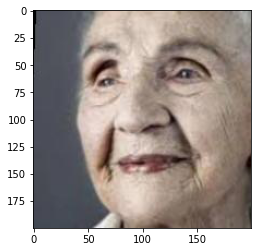

Age : 100  | Predicted : 32
Gender : Female  | Predicted : Female
Race : White  | Predicted : Black




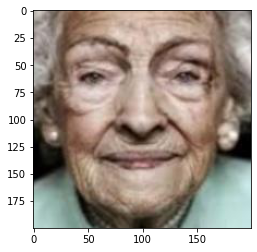

Age : 100  | Predicted : 36
Gender : Female  | Predicted : Female
Race : White  | Predicted : Black




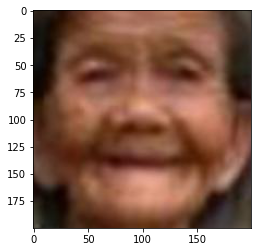

Age : 100  | Predicted : 31
Gender : Female  | Predicted : Female
Race : Asian  | Predicted : Black




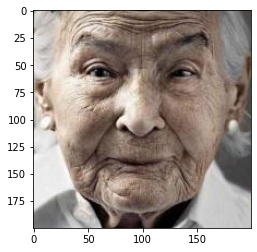

Age : 100  | Predicted : 37
Gender : Female  | Predicted : Female
Race : Asian  | Predicted : Black




In [33]:
for i in range(10) :
    age,gender,race = model.predict(test_dataloader.__getitem__(i)[0], verbose=0)
    gender = (gender>0.5).ravel()+0
    race = np.argmax(race, axis=1)
    
    plt.figure()
    plt.imshow(Image.open(df['image'].iloc[i]))
    plt.show()
    
    print('Age :', test_df['age'][0], ' | Predicted :', int(age))
    print('Gender :', dataset_dict['gender_id'][test_df['gender'][i]], ' | Predicted :',dataset_dict['gender_id'][gender[0]])
    print('Race :', dataset_dict['race_id'][test_df['race'][i]], ' | Predicted :',dataset_dict['race_id'][gender[0]])
    print('\n')